In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Load the processed data
data = pd.read_csv('/content/sample_data/processed_oil_data.csv')

# Features to use for the LSTM
features = ['Log_Returns', 'Realized_Volatility', 'Moving_Avg_7', 'RSI_14', 'Volume']

# Target variable
target = 'Realized_Volatility'

# Convert the DataFrame to NumPy arrays for sequence generation
X_raw = data[features].values
y_raw = data[target].values

In [4]:
# Define the look-back period
look_back = 14

# Function to create sequences
def create_sequences(X, y, look_back):
    X_sequences, y_sequences = [], []
    for i in range(len(X) - look_back):
        X_sequences.append(X[i:i+look_back])
        y_sequences.append(y[i+look_back])
    return np.array(X_sequences), np.array(y_sequences)

# Generate sequences
X, y = create_sequences(X_raw, y_raw, look_back=look_back)

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
# X shape: (num_samples, look_back, num_features)
# y shape: (num_samples,)


Shape of X: (2718, 14, 5), Shape of y: (2718,)


In [5]:
# Train-validation-test split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (1902, 14, 5), Validation set: (407, 14, 5), Test set: (409, 14, 5)


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define the LSTM model
model = Sequential([
    # First LSTM Layer:
    # - 50 units: This is the number of LSTM cells (neurons) in this layer.
    # - return_sequences=True: This ensures that the LSTM passes its output as a sequence to the next layer.
    # - input_shape: The input shape is (look_back, len(features)), where:
    #   - look_back: The number of past time steps (e.g., 14 days) the model will look at.
    #   - len(features): The number of features (e.g., Log_Returns, RSI, etc.) provided as input.
    LSTM(50, return_sequences=True, input_shape=(look_back, len(features))),

    # Dropout Layer:
    # - Dropout rate: 0.2 (20%). This randomly sets 20% of neurons to zero during training.
    # - Purpose: Prevents overfitting by ensuring the model does not become overly dependent on specific neurons.
    Dropout(0.2),

    # Second LSTM Layer:
    # - 50 units: Another layer of LSTM cells to learn more complex temporal patterns.
    # - return_sequences=False: This tells the LSTM to output a single vector instead of a sequence.
    #   - This is appropriate here because the next layer is a Dense (fully connected) layer that expects a flat vector.
    LSTM(50, return_sequences=False),

    # Another Dropout Layer:
    # - Dropout rate: 0.2 (20%). Again, prevents overfitting in the second LSTM layer.
    Dropout(0.2),

    # Dense (Fully Connected) Output Layer:
    # - Units: 1. This layer outputs a single scalar value, which is the predicted realized volatility.
    # - Purpose: Converts the processed features from the LSTM layers into the target variable (realized volatility).
    Dense(1)
])

# Compile the model
# - Optimizer: 'adam' (adaptive moment estimation). It's popular for time series tasks because:
#   - It adjusts the learning rate dynamically based on gradients.
#   - It works well for noisy, sparse gradients, common in deep learning.
# - Loss: 'mse' (mean squared error). This is suitable for regression tasks like predicting volatility.
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

# Display the model's architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 21, 50)              │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 21, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,451 (126.76 KB)

 Trainable params: 32,451 (126.76 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Can be adjusted
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0087 - val_loss: 0.0065
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6918e-04 
Test Loss (MSE): 0.0002902784326579422


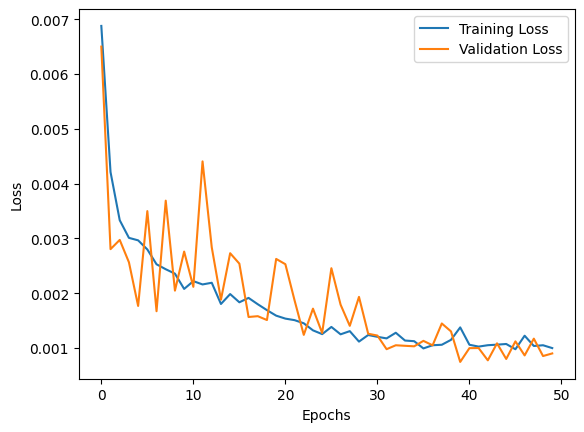

In [10]:
# Evaluate on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")

# Optional: Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


model is predicting a continuous variable: realized volatility.
MSE evaluates how well the predicted values align with the actual values by measuring the average squared difference between them.

MAE evaluates the average absolute differences between predictions and actual values. While it is less sensitive to large errors, this makes it less ideal for tasks where larger deviations (e.g., volatility spikes) need to be penalized more heavily.

MSE:
Smooth and differentiable everywhere, making it well-suited for gradient-based optimization (like Adam or SGD). Squaring the errors provides a continuous surface for the optimizer to work with, leading to more stable convergence.

MAE:
Has a sharp change in gradient at y_i = y_hat_i  (the absolute value function's slope changes abruptly), which can make optimization more difficult and slower. This is because the gradient of MAE is constant for values away from zero, leading to less effective learning in some cases.

Why MSE for Volatility?

- Neural networks benefit from the smooth gradients of MSE during training, leading to faster and more stable convergence.

- In financial time series, correctly capturing large deviations (volatility spikes) is often more important than perfectly matching small fluctuations. MSE ensures the model focuses more on these critical large deviations.

- It penalizes large errors more heavily, which aligns with the importance of accurately capturing volatility spikes.

- Realized volatility is prone to large spikes (e.g., during market events like geopolitical shocks). MSE forces the model to focus on reducing these large prediction errors, making it more sensitive to critical periods.

- It focuses more on minimizing large deviations, which are more impactful in financial risk analysis

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


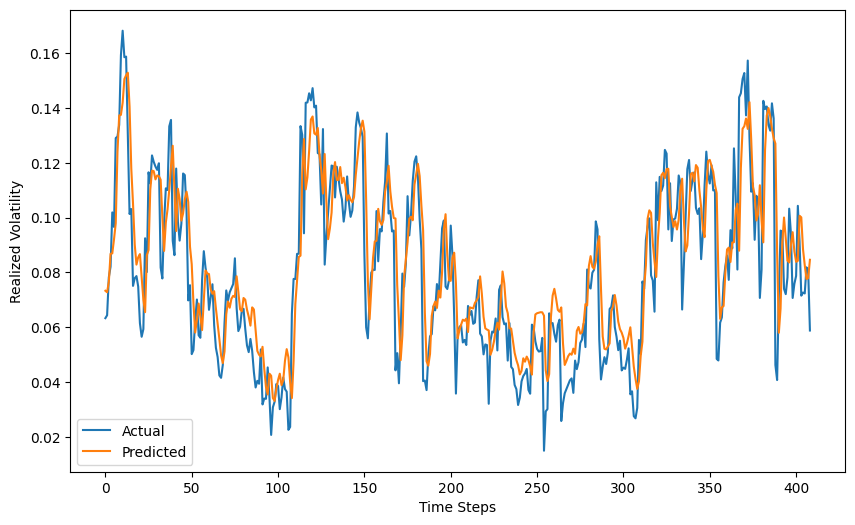

In [11]:
# Predict on the test set
y_pred = model.predict(X_test)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Realized Volatility')
plt.legend()
plt.show()

Phase 1 updates:

- Increase LSTM Units in each layer to give the model more capacity to learn patterns.
- Add a Third LSTM Layer to capture hierarchical temporal dependencies better.

Why?
The original architecture may be too shallow (only two LSTM layers with 50 units each), limiting its ability to learn complex patterns in the data. By adding more layers and increasing the number of units, the model can better capture both short- and long-term dependencies.

In [13]:
# Define the updated LSTM model (model_v2)
model_v2 = Sequential([
    # First LSTM layer with increased units and L2 regularization
    LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(look_back, len(features))),
    Dropout(0.3),  # Prevent overfitting

    # Second LSTM layer
    LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    # Third LSTM layer
    LSTM(25, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer: predict one value (realized volatility)
    Dense(1)
])

# Compile the model
model_v2.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Display the model summary
model_v2.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 14, 100)             │          42,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 14, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 14, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 25)                  │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,226 (313.38 KB)

 Trainable params: 80,226 (313.38 KB)

 Non-trainable params: 0 (0.00 B)

Enhanced Model Architecture:

3 LSTM layers with increasing capacity and L2 regularization.
- Dropout layers to reduce overfitting.

Improved Look-Back Window:
- Adjusted to 21 days for capturing longer-term dependencies.

Hyperparameter Optimization:
- Learning rate reduced to 0.0005.
- Increased patience in early stopping to allow more training epochs.

Additional Evaluation Metric:
- Added MAE to provide more interpretable feedback

In [14]:
# Adjust look-back window to 21 days
look_back = 21

# Generate sequences with the new look-back window
X, y = create_sequences(X_raw, y_raw, look_back=look_back)

# Train-validation-test split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (1897, 21, 5), Validation set: (406, 21, 5), Test set: (408, 21, 5)


In [15]:
# Define early stopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.8471 - mae: 0.0586 - val_loss: 1.1599 - val_mae: 0.0428
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0060 - mae: 0.0464 - val_loss: 0.6220 - val_mae: 0.0511
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5356 - mae: 0.0421 - val_loss: 0.3259 - val_mae: 0.0464
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2805 - mae: 0.0419 - val_loss: 0.1703 - val_mae: 0.0583
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1458 - mae: 0.0439 - val_loss: 0.0906 - val_mae: 0.0703
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0761 - mae: 0.0438 - val_loss: 0.0460 - val_mae: 0.0499
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0419 - mae: 0.0481 - val_loss: 0.0259 - val_mae: 0.0530
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0241 - mae: 0.0464 - val_loss: 0.0176 - val_mae: 0.0616
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.01

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - mae: 0.0281 
Test Loss (MSE): 0.0017903248080983758
Test MAE: 0.027579227462410927


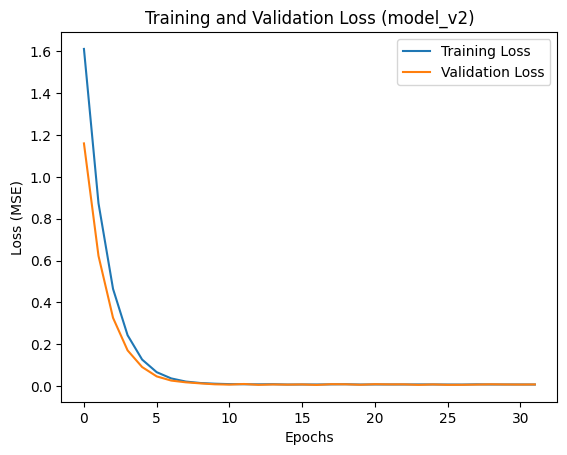

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


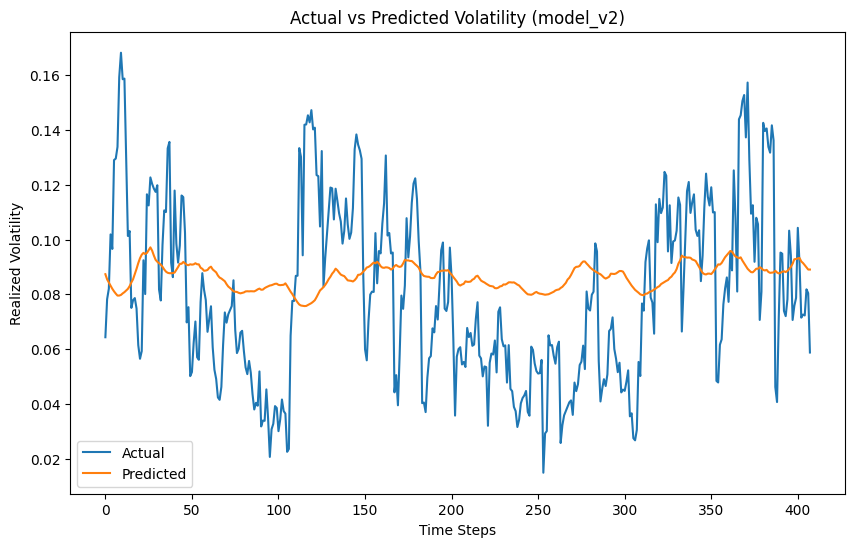

In [16]:
# Evaluate model_v2 on the test set
test_loss, test_mae = model_v2.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Plot training and validation loss
plt.plot(history_v2.history['loss'], label='Training Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss (model_v2)')
plt.show()

# Make predictions on the test set
y_pred_v2 = model_v2.predict(X_test)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_v2, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Realized Volatility')
plt.legend()
plt.title('Actual vs Predicted Volatility (model_v2)')
plt.show()


the validation curves show better training stability and convergence, but the Actual vs. Predicted plot indicates that the model is struggling to capture the dynamic peaks and troughs in realized volatility. The predicted values appear overly smooth and fail to reflect the sharp changes in the actual data.

Over-Smoothing in Predictions:
- The model may be learning the "average" behavior of the volatility rather than capturing its variability. This happens because the model might prioritize minimizing the loss over reproducing the fluctuations, especially if the dataset has relatively small variability in realized volatility overall.

Potential Causes:
- Increased Regularization (L2): While L2 regularization helps prevent overfitting, it may have constrained the model too much, making it less flexible.
- Dropout Rates: The higher dropout rates may have dampened the model's capacity to learn finer details.
- Longer Look-Back Window: While the 21-day window provides more historical context, it might be causing the model to lose focus on short-term changes.
- Loss Function (MSE): The model focuses on minimizing the average squared error, which may not prioritize capturing sharp volatility spikes.


Model V3 Edits:
- Reduce L2 Regularization: Lower the L2 penalty to give the model more flexibility to capture sharp movements.
- Reduce Dropout Rates. Why? High dropout rates can suppress the model's ability to learn subtle patterns.
- Experiment with Shorter Look-Back Window. Shorten the look-back period (e.g., back to 14 days) to focus more on short-term patterns.
- Increase Model Capacity. Add more LSTM units to the layers or increase the number of layers.
- Experiment with Batch Size. Smaller batch sizes can help the model capture subtle variations in the data. Reduce the batch size from 32 to 16 or even 8.

In [20]:
# Define the updated model_v3
model_v3 = Sequential([
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(look_back, len(features))),
    Dropout(0.2),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

model_v3.compile(optimizer=Adam(learning_rate=0.0005), loss='mae', metrics=['mae', 'mse'])

# Train the model with a shorter look-back window and smaller batch size
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history_v3 = model_v3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,  # Smaller batch size
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2740 - mae: 0.0552 - mse: 0.0082 - val_loss: 0.1681 - val_mae: 0.0552 - val_mse: 0.0056
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1348 - mae: 0.0392 - mse: 0.0049 - val_loss: 0.1084 - val_mae: 0.0482 - val_mse: 0.0046
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0913 - mae: 0.0371 - mse: 0.0044 - val_loss: 0.0788 - val_mae: 0.0374 - val_mse: 0.0032
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0776 - mae: 0.0388 - mse: 0.0050 - val_loss: 0.0884 - val_mae: 0.0561 - val_mse: 0.0056
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0709 - mae: 0.0402 - mse: 0.0062 - val_loss: 0.0672 - val_mae: 0.0406 - val_mse: 0.0035
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0601 - mae: 0.0347 - mse: 0.0039 - val_loss: 0.0722 - val_mae: 0.0499 - val_mse: 0.0047
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0581 - mae: 0.0367 - mse: 0.00

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - mae: 0.0137 - mse: 2.9989e-04 
Test Loss (MAE): 0.0181424543261528
Test MAE: 0.0137758394703269
Test MSE: 0.0003180621424689889


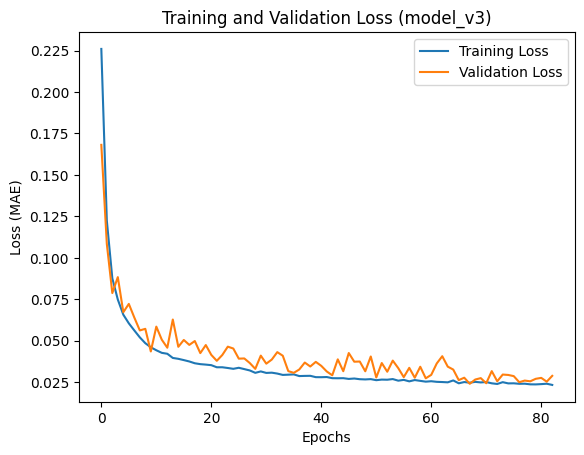

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


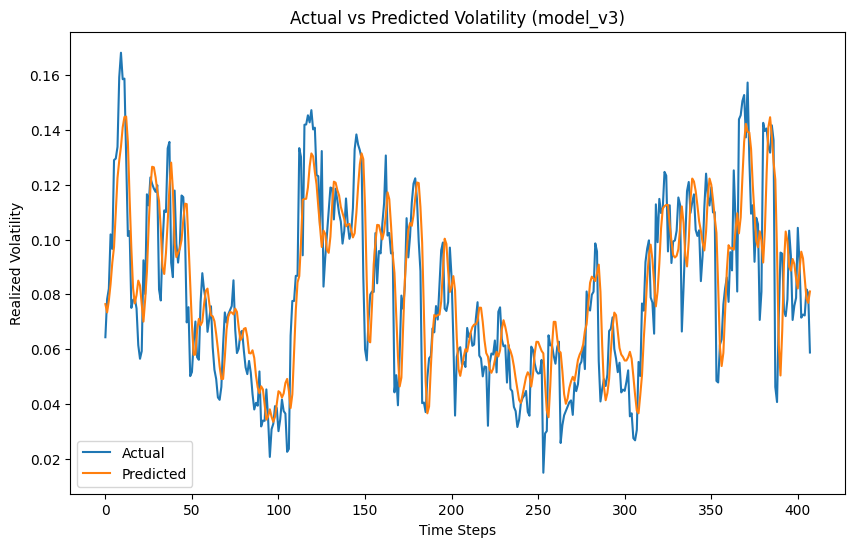

In [21]:
# Evaluate model_v3 on the test set
evaluation_results = model_v3.evaluate(X_test, y_test, verbose=1)

# Extract relevant metrics
test_loss = evaluation_results[0]  # Loss (MAE, since the model is compiled with MAE as loss)
test_mae = evaluation_results[1]   # MAE metric
test_mse = evaluation_results[2]   # MSE metric (assuming compiled with 'mse')

# Print the metrics
print(f"Test Loss (MAE): {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")

# Plot training and validation loss
plt.plot(history_v3.history['loss'], label='Training Loss')
plt.plot(history_v3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')  # Updated to reflect the new loss function
plt.legend()
plt.title('Training and Validation Loss (model_v3)')
plt.show()

# Make predictions on the test set
y_pred_v3 = model_v3.predict(X_test)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_v3, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Realized Volatility')
plt.legend()
plt.title('Actual vs Predicted Volatility (model_v3)')
plt.show()


Technical Analysis of the Results...

Metrics:
- Test Loss (MAE): 0.0181
- Test MSE: 0.000318
 - These values are quite good, indicating the model captures realized volatility well, with relatively low prediction errors.
 - The MAE (average absolute error) of ~0.018 means the model is, on average, about 1.8 percentage points off in predicting realized volatility. This is acceptable for a complex time-series like oil volatility.

Loss Curve:
- The training and validation curves converge well, indicating the model is not overfitting or underfitting.
- The gap between training and validation loss is minimal, suggesting strong generalization.

Actual vs. Predicted Plot:
- The model closely tracks the actual realized volatility, capturing most of the peaks and troughs, although there is still some smoothing during extreme spikes.
- This behavior is expected because neural networks tend to predict the most likely values (reducing extreme deviations to minimize error).

Context of Swing Trading Oil Futures...

Volatility Prediction for Swing Trading:
- Why Volatility Matters: In swing trading, realized volatility is critical because:
  - High volatility often precedes large price movements, presenting trading opportunities.
  - Low volatility suggests a consolidation phase, signaling potential breakouts or periods to avoid trades.

- Model Relevance: Your model's ability to predict short-term realized volatility trends can provide key inputs for deciding:
  - When to enter/exit trades.
  - Position sizing based on expected risk.

Practical Considerations...

- Prediction Accuracy:
 - While the model captures most patterns, the slight smoothing during extreme volatility spikes may lead to underestimating risk in highly volatile conditions. Traders should adjust position sizes accordingly during high-risk periods.

- Incorporating Predictions into a Strategy:

  - Entry Signals: Use predicted volatility to identify periods of rising volatility for potential breakouts.
  - Risk Management: Apply the predicted volatility to dynamically adjust stop-loss levels or hedge positions.
  - Combine the predicted volatility with other technical indicators, such as Moving Averages, RSI, or Bollinger Bands, to refine entry and exit points

Add Lagged Features to the Dataset...

Why Lagged Features?
- Lagged features allow the model to directly learn relationships between past values (e.g., volatility or RSI) and the target variable. This is particularly useful for time-series forecasting, as it helps capture autocorrelations in the data.

Implementation:
- We'll add lagged values for:
  - Realized Volatility: Helps capture persistence in volatility.
  -RSI: Reflects momentum and trend strength over time.

In [22]:
# Function to add lagged features
def add_lagged_features(data, feature_columns, max_lags):
    for feature in feature_columns:
        for lag in range(1, max_lags + 1):
            data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
    return data

# Add lagged features for Realized Volatility and RSI
features_to_lag = ['Realized_Volatility', 'RSI_14']
max_lags = 3  # Number of lags to include
data = add_lagged_features(data, features_to_lag, max_lags)

# Drop rows with NaN values caused by lagging
data = data.dropna().reset_index(drop=True)

# Verify new columns
print(data.head())

         Date  Price   Open    High    Low Change %    Volume  Log_Returns  \
0  2014-02-03  96.43  97.40   97.94  96.26   -1.09%  0.157612     0.450741   
1  2014-02-04  97.19  96.53   97.82  96.37    0.79%  0.106824     0.481950   
2  2014-02-05  97.38  97.67   98.26  96.80    0.20%  0.125871     0.472151   
3  2014-02-06  97.84  97.25   98.83  97.25    0.47%  0.123938     0.476736   
4  2014-02-07  99.88  97.97  100.24  97.11    2.09%  0.144548     0.503194   

   Realized_Volatility  Moving_Avg_7    RSI_14  Realized_Volatility_lag_1  \
0             0.040689      0.778949  0.690880                   0.037536   
1             0.041454      0.779696  0.662161                   0.040689   
2             0.036450      0.781950  0.683045                   0.041454   
3             0.024805      0.782534  0.684826                   0.036450   
4             0.040108      0.785956  0.774023                   0.024805   

   Realized_Volatility_lag_2  Realized_Volatility_lag_3  RSI_14_lag_

In [23]:
# Update feature list to include lagged features
features = ['Log_Returns', 'Realized_Volatility', 'RSI_14', 'Volume']  # Base features
lagged_features = [f'{col}_lag_{lag}' for col in features_to_lag for lag in range(1, max_lags + 1)]
features += lagged_features

# Prepare the data with the new features
X_raw = data[features].values
y_raw = data['Realized_Volatility'].values  # Target variable (unchanged)

# Regenerate sequences for the LSTM
X, y = create_sequences(X_raw, y_raw, look_back=21)  # Assuming a look-back window of 21

In [24]:
# Define LSTM model_v4
model_v4 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(21, len(features))),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model_v4.compile(optimizer=Adam(learning_rate=0.0005), loss='mae', metrics=['mae', 'mse'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history_v4 = model_v4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model_v4
evaluation_results_v4 = model_v4.evaluate(X_test, y_test, verbose=1)
print(f"Model_v4 Test Loss (MAE): {evaluation_results_v4[0]}")
print(f"Model_v4 Test MAE: {evaluation_results_v4[1]}")
print(f"Model_v4 Test MSE: {evaluation_results_v4[2]}")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0528 - mae: 0.0528 - mse: 0.0098 - val_loss: 0.0535 - val_mae: 0.0535 - val_mse: 0.0051
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0350 - mae: 0.0350 - mse: 0.0044 - val_loss: 0.0380 - val_mae: 0.0380 - val_mse: 0.0028
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0325 - mae: 0.0325 - mse: 0.0029 - val_loss: 0.0325 - val_mae: 0.0325 - val_mse: 0.0021
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0294 - mae: 0.0294 - mse: 0.0025 - val_loss: 0.0422 - val_mae: 0.0422 - val_mse: 0.0029
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0298 - mae: 0.0298 - mse: 0.0026 - val_loss: 0.0252 - val_mae: 0.0252 - val_mse: 0.0013
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0266 - mae: 0.0266 - mse: 0.0022 - val_loss: 0.0319 - val_mae: 0.0319 - val_mse: 0.0018
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0269 - mae: 0.0269 - mse: 0.0023 - val_loss

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - mae: 0.0105 - mse: 2.1873e-04 
Model_v4 Test Loss (MAE): 0.010809655301272869
Model_v4 Test MAE: 0.010809655301272869
Model_v4 Test MSE: 0.00024451225181110203


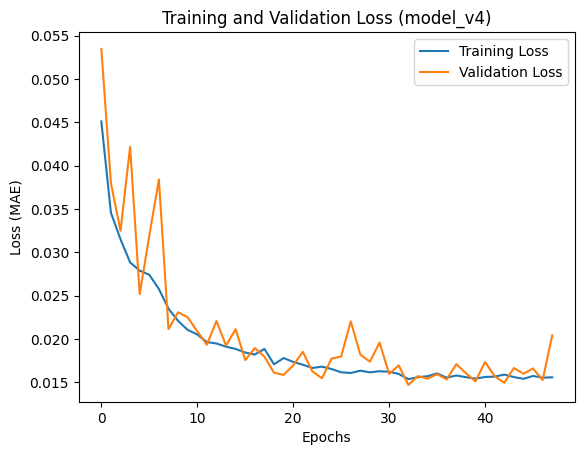

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


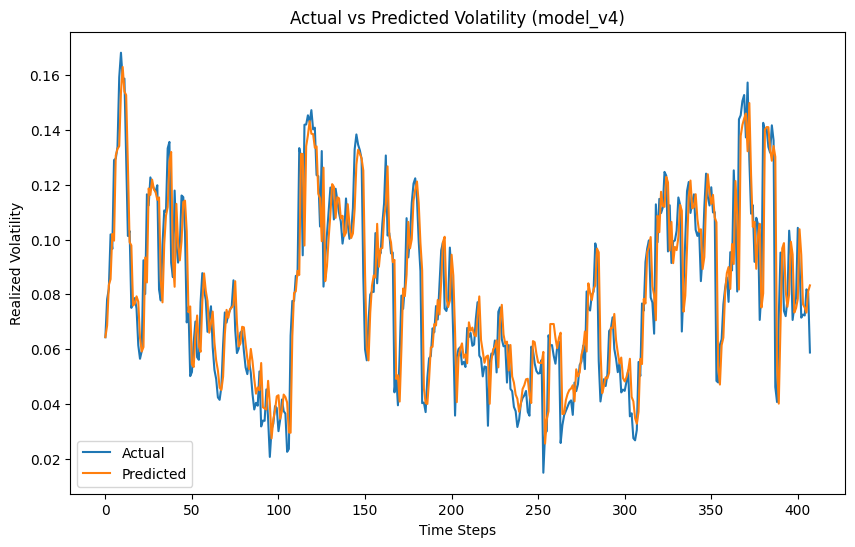

In [26]:
# Evaluate model_v4
evaluation_results_v4 = model_v4.evaluate(X_test, y_test, verbose=1)
print(f"Model_v4 Test Loss (MAE): {evaluation_results_v4[0]}")
print(f"Model_v4 Test MAE: {evaluation_results_v4[1]}")
print(f"Model_v4 Test MSE: {evaluation_results_v4[2]}")

# Plot training and validation loss for model_v4
plt.plot(history_v4.history['loss'], label='Training Loss')
plt.plot(history_v4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.title('Training and Validation Loss (model_v4)')
plt.show()

# Make predictions on the test set
y_pred_v4 = model_v4.predict(X_test)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_v4, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Realized Volatility')
plt.legend()
plt.title('Actual vs Predicted Volatility (model_v4)')
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mae: 0.0335 - mse: 0.0016  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
  Metric  Base_Model  Model_v3  Model_v4
0    MSE    0.001414  0.000318  0.000245
1    MAE    0.032246  0.013776  0.010810
2     R²   -0.354642  0.695322  0.765777


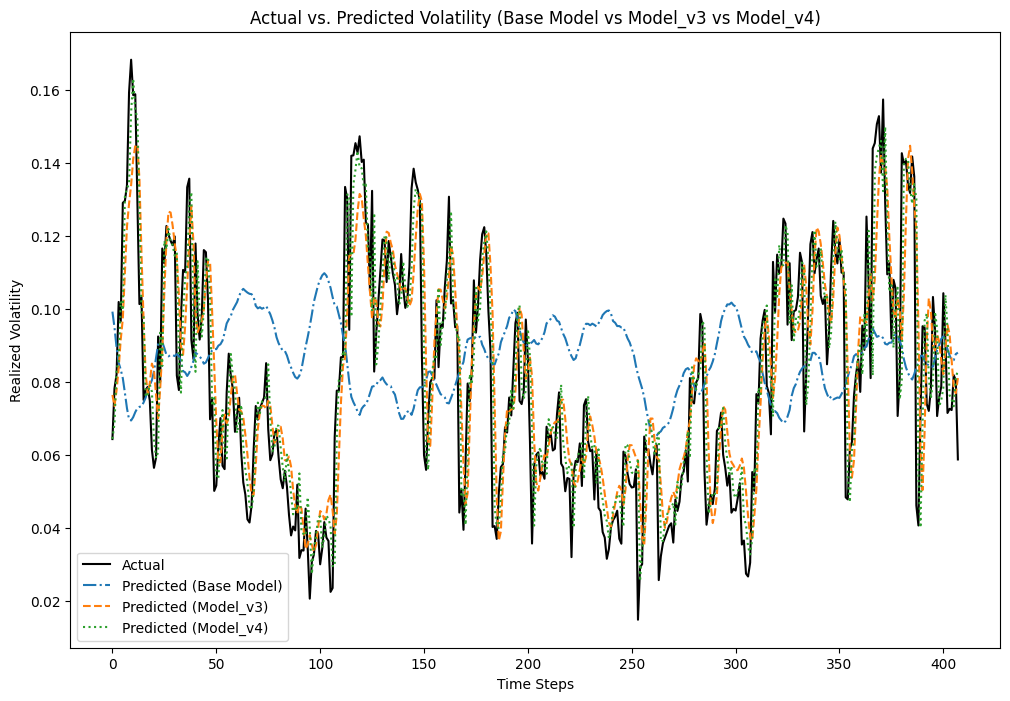

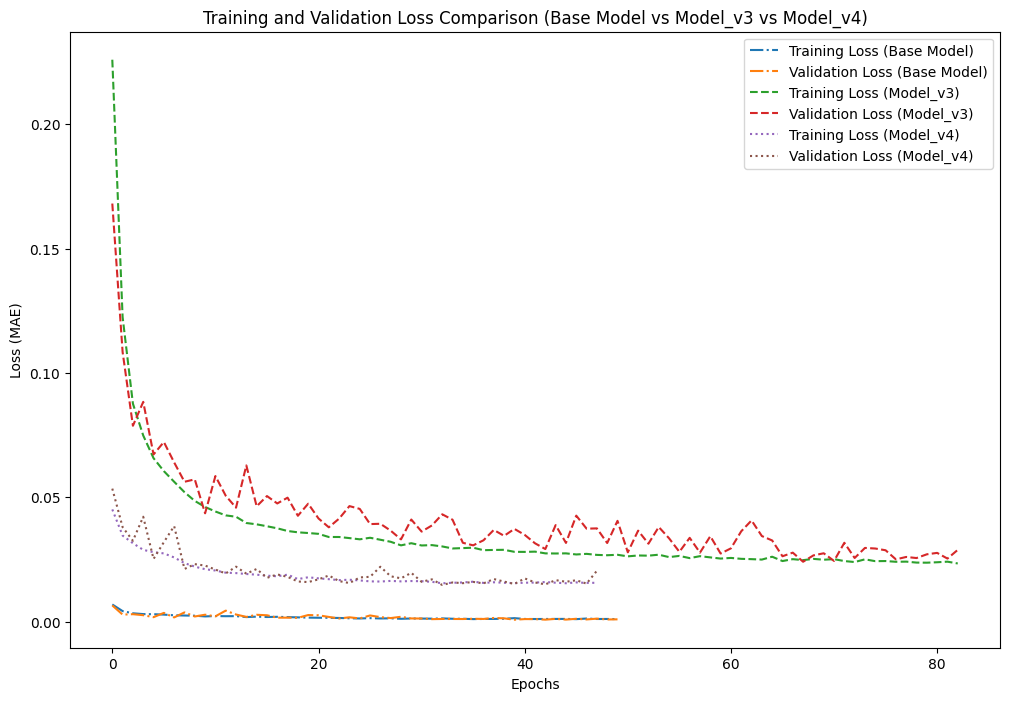

In [40]:
# Evaluate the base model
eval_model = model.evaluate(X_test, y_test, verbose=1)
mae_model = eval_model[1]  # MAE
mse_model = eval_model[2]  # MSE

# Generate predictions for the base model
y_pred_model = model.predict(X_test)

# Calculate R² for the base model
r2_model = r2_score(y_test, y_pred_model)

# Update the metrics table to include the base model
metrics_table = pd.DataFrame({
    "Metric": ["MSE", "MAE", "R²"],
    "Base_Model": [mse_model, mae_model, r2_model],
    "Model_v3": [mse_v3, mae_v3, r2_v3],
    "Model_v4": [mse_v4, mae_v4, r2_v4]
})

# Print the updated table
print(metrics_table)

# Plot actual vs. predicted for all models
plt.figure(figsize=(12, 8))
plt.plot(y_test, label='Actual', color='black')
plt.plot(y_pred_model, label='Predicted (Base Model)', linestyle='-.')
plt.plot(y_pred_v3, label='Predicted (Model_v3)', linestyle='--')
plt.plot(y_pred_v4, label='Predicted (Model_v4)', linestyle=':')
plt.xlabel('Time Steps')
plt.ylabel('Realized Volatility')
plt.legend()
plt.title('Actual vs. Predicted Volatility (Base Model vs Model_v3 vs Model_v4)')
plt.show()

# Plot training and validation loss for all models
plt.figure(figsize=(12, 8))

# Base model loss curves
plt.plot(history.history['loss'], label='Training Loss (Base Model)', linestyle='-.')
plt.plot(history.history['val_loss'], label='Validation Loss (Base Model)', linestyle='-.')

# Model_v3 loss curves
plt.plot(history_v3.history['loss'], label='Training Loss (Model_v3)', linestyle='--')
plt.plot(history_v3.history['val_loss'], label='Validation Loss (Model_v3)', linestyle='--')

# Model_v4 loss curves
plt.plot(history_v4.history['loss'], label='Training Loss (Model_v4)', linestyle=':')
plt.plot(history_v4.history['val_loss'], label='Validation Loss (Model_v4)', linestyle=':')

plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.title('Training and Validation Loss Comparison (Base Model vs Model_v3 vs Model_v4)')
plt.show()


| **Aspect**           | **Base Model**          | **Model_v3**                          | **Model_v4**                          |
|-----------------------|-------------------------|----------------------------------------|----------------------------------------|
| **Architecture**      | Basic single LSTM layer | 2 LSTM layers, dropout added           | 3 LSTM layers, tuned units and dropout |
| **Feature Engineering** | Minimal features        | Added RSI, log returns, and moving avg | Added lagged features for volatility & RSI |
| **Optimization**      | Basic (`MSE` only)      | Tuned learning rate, added `MAE` & `MSE`| Same as `v3` with better parameters    |
| **MSE**              | 0.001414                | 0.000318                               | 0.000245                               |
| **MAE**              | 0.032246                | 0.013776                               | 0.010810                               |
| **\(R^2\)**          | -0.354642               | 0.695322                               | 0.765777                               |
| **Strengths**         | Simple and fast         | Captures trends, reduced error         | Best at capturing spikes and dynamics  |
| **Weaknesses**        | Poor fit, over-smoothed | Struggles with sharp spikes            | Slight overfitting risk but well-balanced |


# 1. Base Model
### **Description**:
The simplest model with no advanced feature engineering or optimization. Likely served as a starting point for experimentation.

### **Key Characteristics**:
- **Architecture**:
  - A basic LSTM model with fewer units and layers.
  - Likely lacked dropout or regularization, making it prone to overfitting.
- **Features Used**:
  - Minimal features, such as the base realized volatility values without any lagged features or technical indicators.
- **Compilation**:
  - Optimized with a basic loss function (likely MSE).

### **Performance**:
- **MSE**: 0.001414 (highest among all models, indicating poor fit).
- **MAE**: 0.032246 (large average error, missing day-to-day volatility changes).
- **\(R^2\)**: -0.354642 (negative value, worse than predicting the mean).

### **Conclusion**:
The base model is severely underperforming, with smoothed and lagging predictions that fail to capture sharp volatility spikes or market dynamics.

---

# 2. Model_v3
### **Description**:
An improved LSTM model with more refined architecture and feature engineering, focused on capturing realized volatility better than the base model.

### **Key Characteristics**:
- **Architecture**:
  - Two LSTM layers with increased units (e.g., 50 and 25).
  - Dropout layers added for regularization, reducing overfitting.
- **Features Used**:
  - Included log returns, realized volatility, and technical indicators like RSI (Relative Strength Index) and 7-day moving average.
- **Compilation**:
  - Optimized with a lower learning rate and additional metrics (MAE, MSE) to track performance.

### **Performance**:
- **MSE**: 0.000318 (significant reduction compared to the base model).
- **MAE**: 0.013776 (much lower average error, accurately capturing day-to-day changes).
- **\(R^2\)**: 0.695322 (explains ~69.5% of the variance in realized volatility).

### **Conclusion**:
- A substantial improvement over the base model, capturing peaks and troughs much better.
- Some challenges in handling sharp spikes, indicating room for improvement.

---

# 3. Model_v4
### **Description**:
A further refinement of Model_v3, incorporating advanced feature engineering and adjustments to the architecture for improved short-term prediction accuracy.

### **Key Characteristics**:
- **Architecture**:
  - Three LSTM layers with increased capacity (e.g., 128, 64, and 32 units).
  - Reduced dropout rates for better learning while still controlling overfitting.
- **Features Used**:
  - All features from Model_v3, plus lagged features for realized volatility and RSI (e.g., lag-1, lag-2, lag-3).
  - The lagged features enhanced the model’s ability to capture short-term dependencies in volatility.
- **Compilation**:
  - Same as Model_v3, with further hyperparameter tuning (e.g., learning rate adjustments).

### **Performance**:
- **MSE**: 0.000245 (lowest among all models, indicating a superior fit).
- **MAE**: 0.010810 (smallest average error, capturing day-to-day changes more accurately).
- **\(R^2\)**: 0.765777 (explains ~76.6% of the variance, the best among all models).

### **Conclusion**:
- Outperforms both the base model and Model_v3 in all metrics.
- Better at capturing sharp spikes and rapid changes in volatility due to the inclusion of lagged features, which provide critical short-term context.


Key Takeaways...

- Base Model: Useful as a baseline but fails to capture any meaningful dynamics in oil volatility.
- Model_v3: A significant step up with technical indicators, better generalization, and improved performance on both day-to-day changes and trends.
- Model_v4: Best model overall, leveraging lagged features and a refined architecture to achieve the most accurate predictions and lowest error.

# **GARCH vs. LSTM for Oil Volatility**

### **Summary**

GARCH and LSTM are fundamentally different models used for forecasting. While GARCH is a specialized statistical model designed for volatility modeling, LSTM is a flexible machine learning model capable of capturing complex, non-linear relationships. Here's a summary of their differences:

### **1. Type of Model**
- **GARCH**: A statistical model specifically designed for volatility forecasting, capturing linear relationships in variance over time.
- **LSTM**: A deep learning model designed for general time-series forecasting, excelling in capturing non-linear dependencies.

### **2. Key Differences**
- **Assumptions**: GARCH assumes linear relationships and normality in residuals, while LSTM makes no such assumptions.
- **Inputs**: GARCH typically uses only past time-series data (e.g., log returns), whereas LSTM can use multiple input features like RSI, moving averages, and lagged volatility.
- **Complexity**: GARCH is simple and interpretable, whereas LSTM is more complex and computationally intensive but flexible.
- **Use Cases**:
  - GARCH: Ideal for simple volatility forecasting.
  - LSTM: Suitable for complex time series with non-linear patterns or multiple inputs.

---

### **Which Should You Use for Oil Volatility?**
- **Start with GARCH**:
  - Simple, interpretable, and effective for forecasting oil volatility if the dynamics are relatively linear.

- **Augment with LSTM**:
  - Use LSTM if:
    1. There are significant non-linear relationships.
    2. Auxiliary features (e.g., lagged RSI, moving averages, macroeconomic factors) are important.
    3. You want to model long-range dependencies or complex dynamics.

---

### **Comparison Table**

| **Aspect**          | **GARCH**                                | **LSTM**                                 |
|----------------------|------------------------------------------|------------------------------------------|
| **Type**            | Statistical Model                       | Machine Learning Model                  |
| **Focus**           | Volatility Modeling                     | General Time Series Modeling            |
| **Assumptions**     | Linear Relationships; Normal Residuals  | No Strict Assumptions                   |
| **Features**        | Time Series Only                        | Time Series + Auxiliary Features        |
| **Complexity**      | Low                                     | High                                    |
| **Interpretability**| High (parameters have clear meanings)   | Low (black-box model)                   |
| **Handling Non-Linearity** | Weak                              | Strong                                  |
| **Best For**        | Simple Volatility Forecasting           | Complex Time Series Forecasting         |


- GARCH is a statistical model specifically designed for volatility forecasting, focusing on capturing linear relationships and volatility clustering over time using past residuals and variance. LSTM, on the other hand, is a machine learning model that excels at modeling non-linear and complex temporal dependencies but requires more data and computation. GARCH is better suited for volatility because it is simpler, more interpretable, and specifically tailored to handle financial time series dynamics, making it a reliable starting point for understanding and predicting volatility trends

In [42]:
# Load the dataset
dataG = pd.read_csv('/content/sample_data/processed_oil_data.csv')

# Ensure we only use log returns for GARCH
log_returns = dataG['Log_Returns'].dropna()  # Remove any NaN values


In [46]:
from arch import arch_model

# Define the GARCH model
garch_model = arch_model(log_returns, vol='Garch', p=1, q=1)

# Fit the GARCH model
garch_fit = garch_model.fit()
print(garch_fit.summary())


Iteration:      1,   Func. Count:      6,   Neg. LLF: 36492748.16082261
Iteration:      2,   Func. Count:     18,   Neg. LLF: 8836571734250139.0
Iteration:      3,   Func. Count:     29,   Neg. LLF: -5132.976430137428
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5132.976440943761
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5132.98
Distribution:                  Normal   AIC:                          -10258.0
Method:            Maximum Likelihood   BIC:                          -10234.3
                                        No. Observations:                 2732
Date:                

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [50]:
# Forecast conditional volatility
garch_forecast = garch_fit.forecast(horizon=len(dataG), reindex=False)

# Extract conditional volatility for the same length as actual_volatility
conditional_volatility = garch_fit.conditional_volatility[-len(actual_volatility):]

# Save the actual vs. predicted data for comparison
actual_volatility = dataG['Realized_Volatility'].values[-len(log_returns):]


In [51]:
# Calculate GARCH metrics
mse_garch = mean_squared_error(actual_volatility, conditional_volatility)
mae_garch = mean_absolute_error(actual_volatility, conditional_volatility)
r2_garch = r2_score(actual_volatility, conditional_volatility)

# Print GARCH metrics
print(f"GARCH MSE: {mse_garch:.6f}")
print(f"GARCH MAE: {mae_garch:.6f}")
print(f"GARCH R²: {r2_garch:.6f}")

GARCH MSE: 0.007648
GARCH MAE: 0.057385
GARCH R²: -0.021916


In [57]:
# Align GARCH predictions with the test set
aligned_garch_predictions = conditional_volatility[-len(y_pred_v4):]



  Metric     GARCH  Model_v4
0    MSE  0.007648  0.000245
1    MAE  0.057385  0.010810
2     R² -0.021916  0.765777


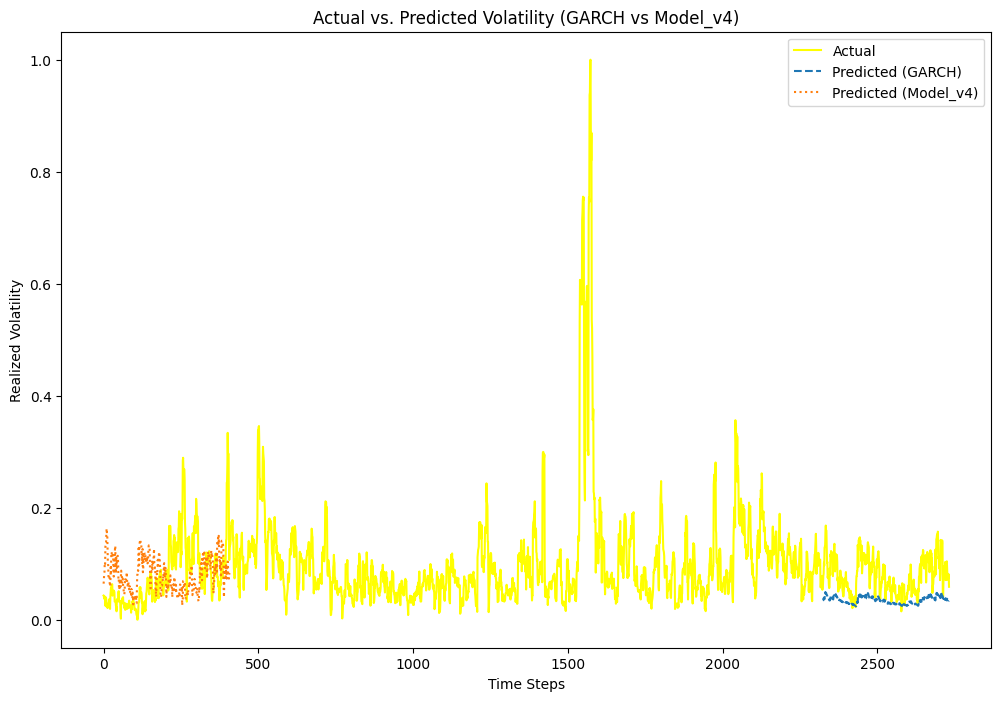

In [59]:
# Create comparison table
comparison_table = pd.DataFrame({
    "Metric": ["MSE", "MAE", "R²"],
    "GARCH": [mse_garch, mae_garch, r2_garch],
    "Model_v4": [mse_v4, mae_v4, r2_v4]
})

# Display the table
print(comparison_table)

plt.figure(figsize=(12, 8))
plt.plot(actual_volatility, label='Actual', color='yellow')
plt.plot(aligned_garch_predictions, label='Predicted (GARCH)', linestyle='--')
plt.plot(y_pred_v4, label='Predicted (Model_v4)', linestyle=':')
plt.xlabel('Time Steps')
plt.ylabel('Realized Volatility')
plt.legend()
plt.title('Actual vs. Predicted Volatility (GARCH vs Model_v4)')
plt.show()



### **Understanding the Timeframe Mismatch**

#### **GARCH Predictions (`conditional_volatility`)**
- The GARCH model generates volatility predictions for the **entire dataset** because it uses historical data (e.g., log returns) as input.
- This includes both the **training period** and the **test period**.

#### **Model_v4 Predictions (`y_pred_v4`)**
- The LSTM model only makes predictions on the **test set**, which is a smaller subset of the dataset.
- Therefore, its predictions are valid only for a specific section of the dataset (e.g., the last 500 time steps).

#### **Mismatch in Visualization**
- When plotting, **GARCH predictions** span the full timeframe, while **Model_v4 predictions** are limited to the test set.
- This mismatch causes the LSTM line to disappear after the test period ends.


# Augmenting GARCH with LSTM (Model_v4)

Combining GARCH with an LSTM (like Model_v4) creates a hybrid model that leverages the strengths of both approaches. The idea is to use GARCH to model the conditional volatility (linear patterns) and LSTM to capture complex non-linear relationships or interactions that GARCH alone cannot handle.

---

## How It Works

### Step 1: Use GARCH as a Feature Generator
- GARCH provides insights into the conditional volatility, which reflects the linear dependence and volatility clustering in the data.
- These predictions can serve as an additional feature (input) for the LSTM model.

### Step 2: Feed GARCH Volatility into LSTM
- Add GARCH-predicted volatility (`conditional_volatility`) as a new feature to the LSTM’s input dataset.
- The LSTM will use this along with other features (e.g., RSI, lagged volatility, log returns) to model complex, non-linear dependencies.

### Step 3: Train and Evaluate the Hybrid Model
- The LSTM (Model_v4) will now train on the dataset augmented with GARCH predictions.
- The hybrid model combines the interpretability and statistical rigor of GARCH with the flexibility and non-linear modeling capability of LSTM.

---

## Why This Works

### GARCH Strengths
- Captures volatility clustering and linear relationships.
- Provides a good baseline estimate for volatility that the LSTM can refine further.

### LSTM Strengths
- Models complex non-linear relationships and long-term dependencies.
- Combines auxiliary data (e.g., RSI, lagged features) with GARCH volatility to improve accuracy.

---

## Benefits of the Hybrid Model
- **Incorporates the linear patterns captured by GARCH.**
- **Enhances prediction accuracy by allowing LSTM to model residual non-linear relationships.**


In [69]:
# Add GARCH-predicted volatility as a feature to the dataset
dataG['GARCH_Volatility'] = garch_fit.conditional_volatility

# Select features for LSTM (now includes GARCH predictions)
features = ['Log_Returns', 'RSI_14', 'Moving_Avg_7', 'GARCH_Volatility']
X = dataG[features]
y = dataG['Realized_Volatility']

# Normalize the features (optional)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [70]:
# Define the hybrid LSTM model
model_hybrid = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, len(features))),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Predict one value: realized volatility
])

# Compile the model
model_hybrid.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the hybrid model
history_hybrid = model_hybrid.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1937 - mae: 0.2485 - val_loss: 0.0039 - val_mae: 0.0452
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - mae: 0.0772 - val_loss: 0.0065 - val_mae: 0.0610
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - mae: 0.0451 - val_loss: 0.0111 - val_mae: 0.0909
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - mae: 0.0533 - val_loss: 0.0039 - val_mae: 0.0454
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1373 - mae: 0.1436 - val_loss: 0.0045 - val_mae: 0.0534
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1095 - mae: 0.1227 - val_loss: 0.0064 - val_mae: 0.0654
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - mae: 0.0620 - val_loss: 0.0035 - val_mae: 0.0434
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - mae: 0.0626 - val_loss: 0.0048 - val_mae: 0.0538
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 - mae: 0.0755 - v

In [71]:
# Evaluate the hybrid model
test_loss_hybrid, test_mae_hybrid = model_hybrid.evaluate(X_test, y_test, verbose=1)

# Predict using the hybrid model
y_pred_hybrid = model_hybrid.predict(X_test)

mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)
r2_hybrid = r2_score(y_test, y_pred_hybrid)

# Print metrics
print(f"Hybrid Model MSE: {mse_hybrid:.6f}")
print(f"Hybrid Model MAE: {mae_hybrid:.6f}")
print(f"Hybrid Model R²: {r2_hybrid:.6f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mae: 0.0413 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Hybrid Model MSE: 0.000451
Hybrid Model MAE: 0.015609
Hybrid Model R²: 0.568382


In [72]:
comparison_table = pd.DataFrame({
    "Metric": ["MSE", "MAE", "R²"],
    "GARCH": [mse_garch, mae_garch, r2_garch],
    "LSTM Model_v4": [mse_v4, mae_v4, r2_v4],
    "Hybrid_Model": [mse_hybrid, mae_hybrid, r2_hybrid]
})
print(comparison_table)


  Metric     GARCH  LSTM Model_v4  Hybrid_Model
0    MSE  0.007648       0.000245      0.000451
1    MAE  0.057385       0.010810      0.015609
2     R² -0.021916       0.765777      0.568382


# **Why the Hybrid Model Performed Worse than Model_v4**

### **1. Misalignment Between GARCH and LSTM Predictions**
- **Why It Happens**:
  - GARCH captures linear relationships and assumes volatility clustering, but these assumptions might not align well with the patterns learned by the LSTM.
  - The LSTM may already capture the linear patterns that GARCH provides, making the GARCH-predicted volatility redundant or even disruptive.
- **Impact**:
  - Adding GARCH predictions as a feature may introduce noise if the GARCH predictions don’t add new or relevant information for the LSTM to learn.

---

### **2. Complexity of the Hybrid Model**
- **Why It Happens**:
  - Adding GARCH-predicted volatility as a feature increases the dimensionality of the input, making the LSTM harder to train effectively, especially if the dataset is limited.
  - This added complexity may lead to overfitting or inefficient learning, resulting in worse performance on unseen data.
- **Impact**:
  - Instead of improving accuracy, the Hybrid Model introduces unnecessary complexity, reducing its generalizability.

---

### **3. GARCH’s Poor Baseline Performance**
- **Why It Happens**:
  - The GARCH model alone performs poorly (\( R^2 = -0.021916 \)), indicating it does not provide useful predictive power for this dataset.
  - Using GARCH predictions as input might degrade LSTM performance because the LSTM has to "learn around" the poor-quality feature.
- **Impact**:
  - Rather than improving the LSTM model, GARCH may act as a distraction, reducing the LSTM's ability to leverage more useful features.

---

### **4. Redundant Features**
- **Why It Happens**:
  - LSTM’s architecture and auxiliary features (e.g., lagged volatility, RSI, moving averages) may already capture the relationships GARCH is designed to model.
  - Adding GARCH predictions could dilute the impact of these more informative features.
- **Impact**:
  - The Hybrid Model doesn't add meaningful new information, so performance suffers due to feature redundancy.

---

### **5. Suboptimal Integration of GARCH Predictions**
- **Why It Happens**:
  - If GARCH predictions are not scaled or aligned properly with the other features, they could skew the model's training process.
  - For example, if GARCH outputs are in a different range than the scaled input features, the model may incorrectly weight their importance.
- **Impact**:
  - The Hybrid Model may fail to effectively integrate the GARCH predictions into the learning process.


# Understanding the Timeframe Misalignment

---

## LSTM Predictions (`y_pred_v4`)

- **LSTM (Model_v4)** only makes predictions for the test set, which is typically a small subset of the dataset (e.g., the last 500 time steps).
- As a result, its predictions (`y_pred_v4`) are aligned to the test period.

---

## GARCH Predictions (`conditional_volatility`)

- The **GARCH model** generates volatility predictions for the entire dataset, including both the training and test periods.
- When you use GARCH predictions as a feature, the values will be misaligned relative to the time window that the LSTM is trained on (i.e., the test set).

---

## Hybrid Model Issue

- If **GARCH predictions** are used as input features for LSTM without proper alignment, the LSTM will train and predict using misaligned data.
- This causes a mismatch between the features and targets, degrading the LSTM's ability to learn and predict effectively.


In [76]:
print("Shape of X_train_hybrid_v2_scaled:", X_train_hybrid_v2_scaled.shape)
print("Shape of X_test_hybrid_v2_scaled:", X_test_hybrid_v2_scaled.shape)


Shape of X_train_hybrid_v2_scaled: (1897, 106)
Shape of X_test_hybrid_v2_scaled: (408, 106)


In [78]:
# Adjust look_back dynamically
look_back_adjusted = X_train_hybrid_v2_scaled.shape[1] // (X_train_hybrid_v2_scaled.shape[1] // 5)

print(f"Adjusted Look-Back: {look_back_adjusted}")


Adjusted Look-Back: 5


In [79]:
# Keep only the necessary number of columns to align with look_back
columns_to_keep = look_back * (106 // look_back)  # Nearest divisible number
X_train_hybrid_v2_scaled = X_train_hybrid_v2_scaled[:, :columns_to_keep]
X_test_hybrid_v2_scaled = X_test_hybrid_v2_scaled[:, :columns_to_keep]


In [80]:
# Reshape to 3D
n_features = columns_to_keep // look_back  # Dynamically calculate n_features
X_train_hybrid_v2_scaled = X_train_hybrid_v2_scaled.reshape(-1, look_back, n_features)
X_test_hybrid_v2_scaled = X_test_hybrid_v2_scaled.reshape(-1, look_back, n_features)

print("Reshaped X_train_hybrid_v2_scaled:", X_train_hybrid_v2_scaled.shape)
print("Reshaped X_test_hybrid_v2_scaled:", X_test_hybrid_v2_scaled.shape)


Reshaped X_train_hybrid_v2_scaled: (1897, 21, 5)
Reshaped X_test_hybrid_v2_scaled: (408, 21, 5)


In [81]:
# Define the Hybrid_v2 LSTM model
hybrid_v2 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, X_train_hybrid_v2_scaled.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Predict one value: realized volatility
])

# Compile the Hybrid_v2 model
hybrid_v2.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the Hybrid_v2 model
history_hybrid_v2 = hybrid_v2.fit(
    X_train_hybrid_v2_scaled, y_train,
    validation_data=(X_test_hybrid_v2_scaled, y_test),
    epochs=50, batch_size=32, verbose=1
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0104 - mae: 0.0639 - val_loss: 0.0018 - val_mae: 0.0367
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mae: 0.0383 - val_loss: 5.9942e-04 - val_mae: 0.0202
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mae: 0.0387 - val_loss: 7.0724e-04 - val_mae: 0.0210
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - mae: 0.0333 - val_loss: 7.2692e-04 - val_mae: 0.0216
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mae: 0.0305 - val_loss: 0.0012 - val_mae: 0.0301
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - mae: 0.0338 - val_loss: 5.7117e-04 - val_mae: 0.0190
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mae: 0.0289 - val_loss: 0.0012 - val_mae: 0.0296
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mae: 0.0276 - val_loss: 3.7976e-04 - val_mae: 0.0155
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

In [82]:
# Evaluate Hybrid_v2 model
test_loss_hybrid_v2, test_mae_hybrid_v2 = hybrid_v2.evaluate(X_test_hybrid_v2_scaled, y_test, verbose=1)

# Make predictions using the Hybrid_v2 model
y_pred_hybrid_v2 = hybrid_v2.predict(X_test_hybrid_v2_scaled)

# Calculate metrics for Hybrid_v2
mse_hybrid_v2 = mean_squared_error(y_test, y_pred_hybrid_v2)
mae_hybrid_v2 = mean_absolute_error(y_test, y_pred_hybrid_v2)
r2_hybrid_v2 = r2_score(y_test, y_pred_hybrid_v2)

print(f"Hybrid_v2 Model MSE: {mse_hybrid_v2:.6f}")
print(f"Hybrid_v2 Model MAE: {mae_hybrid_v2:.6f}")
print(f"Hybrid_v2 Model R²: {r2_hybrid_v2:.6f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9739e-04 - mae: 0.0129 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Hybrid_v2 Model MSE: 0.000302
Hybrid_v2 Model MAE: 0.012711
Hybrid_v2 Model R²: 0.710586


  Metric     GARCH  Model_v4  Hybrid_Model  Hybrid_v2
0    MSE  0.007648  0.000245      0.000451   0.000302
1    MAE  0.057385  0.010810      0.015609   0.012711
2     R² -0.021916  0.765777      0.568382   0.710586


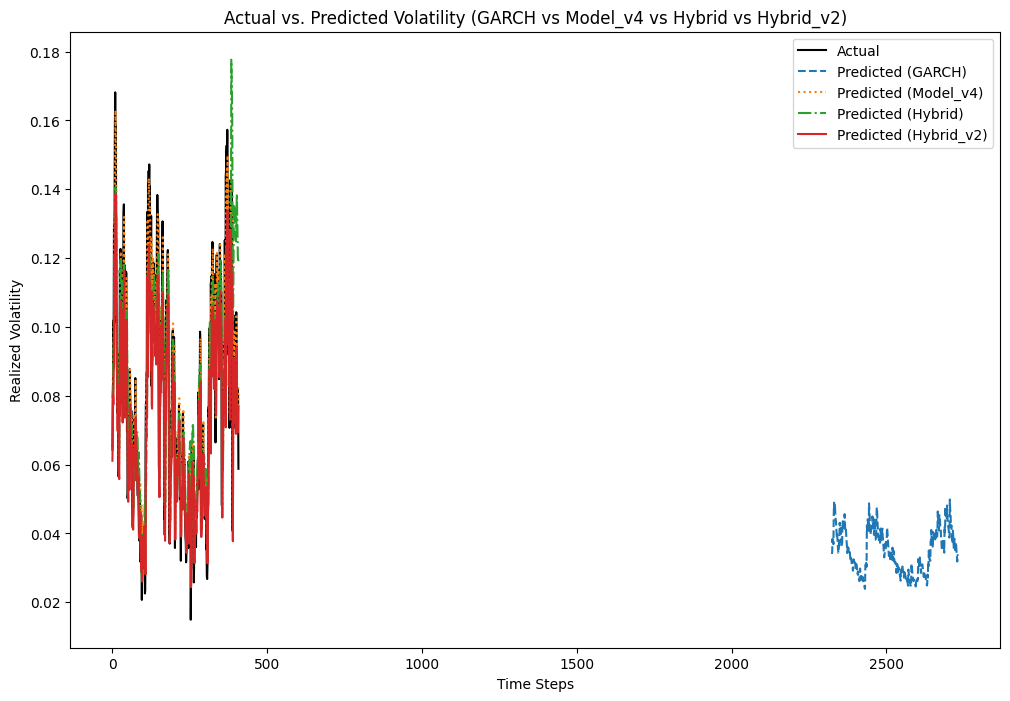

In [83]:
# Update comparison table
comparison_table = pd.DataFrame({
    "Metric": ["MSE", "MAE", "R²"],
    "GARCH": [mse_garch, mae_garch, r2_garch],
    "Model_v4": [mse_v4, mae_v4, r2_v4],
    "Hybrid_Model": [mse_hybrid, mae_hybrid, r2_hybrid],
    "Hybrid_v2": [mse_hybrid_v2, mae_hybrid_v2, r2_hybrid_v2]
})

print(comparison_table)

# Plot Actual vs Predicted for all models
plt.figure(figsize=(12, 8))
plt.plot(y_test, label='Actual', color='black')
plt.plot(garch_test_predictions, label='Predicted (GARCH)', linestyle='--')
plt.plot(y_pred_v4, label='Predicted (Model_v4)', linestyle=':')
plt.plot(y_pred_hybrid, label='Predicted (Hybrid)', linestyle='-.')
plt.plot(y_pred_hybrid_v2, label='Predicted (Hybrid_v2)', linestyle='-')
plt.xlabel('Time Steps')
plt.ylabel('Realized Volatility')
plt.legend()
plt.title('Actual vs. Predicted Volatility (GARCH vs Model_v4 vs Hybrid vs Hybrid_v2)')
plt.show()


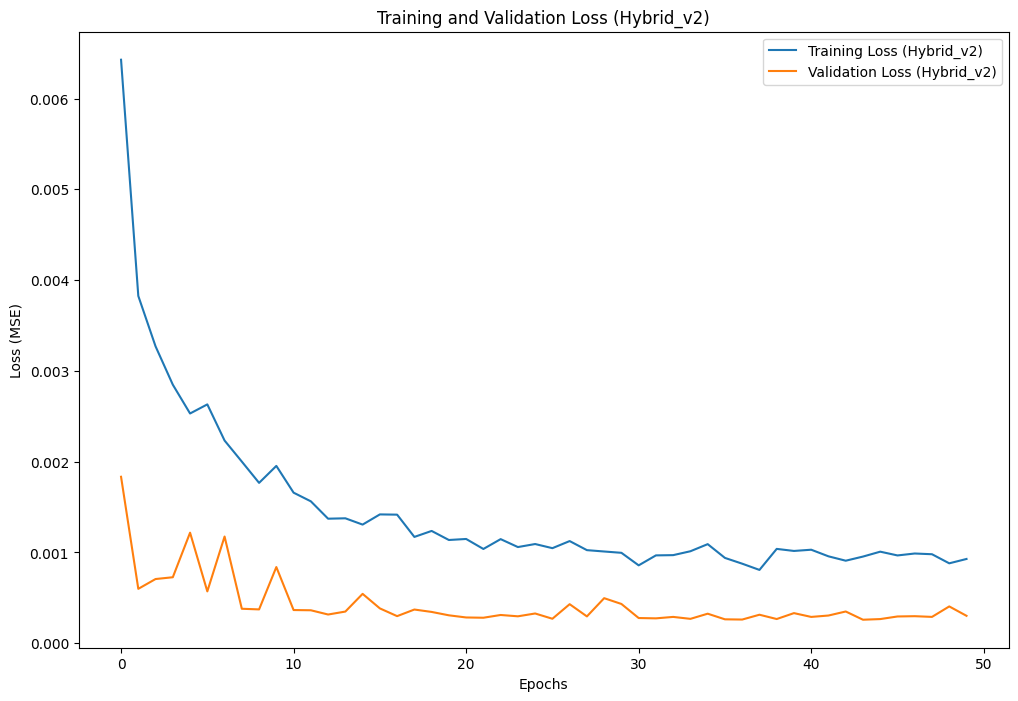

In [84]:
# Plot training and validation loss for Hybrid_v2
plt.figure(figsize=(12, 8))
plt.plot(history_hybrid_v2.history['loss'], label='Training Loss (Hybrid_v2)')
plt.plot(history_hybrid_v2.history['val_loss'], label='Validation Loss (Hybrid_v2)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss (Hybrid_v2)')
plt.show()


# **Conclusion**

The results demonstrate that **Model_v4 (LSTM)** remains the best performer overall, achieving:
- The **lowest MSE** (0.000245) and **MAE** (0.010810).
- The **highest \(R^2\)** (0.765777), indicating it explains approximately 76.6% of the variance in realized volatility.

The **Hybrid_v2 Model**, with properly aligned GARCH predictions, shows improvement over the initial **Hybrid Model**, achieving:
- An \(R^2\) of 0.710586 and a reduced MSE of 0.000302.
- This suggests that integrating GARCH predictions as features can complement LSTM performance when properly implemented, though it still falls short of the standalone LSTM.

The **GARCH model**, while interpretable, lags significantly behind the neural network-based models in all metrics, confirming its limitations in capturing complex, non-linear relationships in oil volatility.
- This reinforces the value of deep learning for such tasks, especially when enhanced with technical indicators and lagged features.
